# Dependencies

In [1]:
import numpy as np
import os

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import scipy
from scipy.optimize import minimize, curve_fit

import pandas as pd

# Functions

## CRC

In [3]:
def f_curve_vec(x, R_b, R_t, x_50, H):
    """
    Dose-response curve function
    
    Parameters:
    ----------
    x   : array
          log_10 of concentration of inhibitor
    R_b : float
          bottom response
    R_t : float
          top response
    x_50: float
          logIC50
    H   : float
          hill slope
    ----------
    return an array of response
    """
    return R_b+(R_t-R_b)/(1+10**(x*H-x_50*H))


def parameter_estimation(data, init_theta=None): 
    """
    Fitting non-linear regression for dose-response curve
    Parameters:
    ----------
    data      : list of two element: x, y
                x is vector of concentration
                y is vector of responsex and y must be same length
    theta     : vector of 4 parameters (bottom response, top response, logIC50, hill slope)
    ----------
    return [theta, ASE, variance]
    """

    # Initial value and boundary for theta
    min_y = min(data['y'])
    max_y = max(data['y'])
    range_y = max_y - min_y

    if init_theta is None:
        init_theta = [min_y, max_y, data['x'][np.argmin(np.square(data['y']-np.mean(data['y'])))], 1.0]
        upper = [min_y + 0.25*range_y, max_y + 0.25*range_y, 20, 20]
        lower = [min_y - 0.25*range_y, max_y - 0.25*range_y, -20, -20]
    else:
        upper = [theta[0] + 0.25*range_y, theta[1] + 0.25*range_y, 20, 20]
        lower = [theta[0] - 0.25*range_y, theta[1] - 0.25*range_y, -20, -20]

    fit_f, var_matrix = curve_fit(f_curve_vec, xdata=np.array(data['x']), ydata=np.array(data['y']),
                                  absolute_sigma=True, p0=init_theta,
                                  bounds=(lower, upper))
    
    # Estimate ASE for theta
    y_hat = f_curve_vec(data['x'], *fit_f)
    sigma = np.sqrt(np.sum((y_hat - data['y'])**2)/(len(y_hat)-4))
    ASE = np.sqrt(np.diag(var_matrix))*sigma #unscale_SE*sigma

    mle = [fit_f, ASE, sigma**2]

    return mle


def scaling_data(y, bottom, top):
    """
    This function is used to normalize data by mean of top and bottom control
    
    Parameters:
    ----------
    y     : vector of response
    bottom: mean of vector of control on the bottom
    top   : mean of vector of control on the top
    ----------

    return vector of normalized response 
    """
    min_y = min(bottom, top)
    max_y = max(bottom, top)
    return (y-min_y)/abs(max_y - min_y)*100

## Downward curve

In [4]:
def plot_curve(data, theta=None, ASE=None, ax=None, line_color='b', line_style = '-', 
               label_curve='Fitting', title_name=None, 
               xlabel='$Log_{10} Inhibitor (M)$', ylabel='% Activity', 
               figure_size=(6.4, 4.8), dpi=80, outfile=None):
    """
    Parameters:
    ----------
    data            : dict of experiment information: x, y, theta
                        x is vector of log10 of inhibitor
                        y is vector of %activity
                        x and y must be same length
                        theta is vector of 4 parameter values
    theta           : vector, if no 'theta' in data, can using this plug-in theta
    ASE             : vector, if no 'ASE' in data, can using this plug-in ASE
    ax              : if None, generating new plot
    line_color      : string, color of fitting line
    line_style      : string, line_style of fitting line
    label_curve     : string, label of fitting line
    title_name      : string, title of the plot
    xlabel, ylabel  : string, label of two axes of plot
    figure_size     : (width, height) size of plot
    dpi             : quality of plot
    outfile         : optional, string, output file for saving plot
    ----------
    return the plot of curve with information of params and their ASE
    """

    try: 
        y = data['y']
    except:
        y = data['response']

    try:
        x = data['x']
    except: 
        x = data['LogConcentration']

    if theta is None: 
        if 'theta' in data.index and 'ASE' in data.index:
            theta = data['theta']
            ASE = data['ASE']
        else:
            print("Please provide the values for 4 parameters.")

    if ax is None:
        plt.figure(figsize=figure_size, dpi=dpi)
        ax = plt.axes()

    conc = np.linspace(min(x), max(x), num=50)
    fitted = f_curve_vec(conc, *theta)

    ax.plot(x, y, 'k.', label='Observed Data')
    ax.plot(conc, fitted, color=line_color, linestyle=line_style, label=label_curve)
    handles, labels = ax.get_legend_handles_labels()

    ax.text(0.65, 0.7,
            r'$R_b$: '+ str('%3.2f' %theta[0]) + ' $\pm$ ' + str('%3.2f' %ASE[0])
            + '\n$R_t$: '+ str('%3.2f' %theta[1]) + ' $\pm$ ' + str('%3.2f' %ASE[1]) 
            + '\n$x_{50}$: '+ str('%3.2f' %theta[2]) + ' $\pm$ ' + str('%3.2f' %ASE[2])
            + '\n$H$: ' + str('%3.2f' %theta[3]) + ' $\pm$ ' + str('%3.2f' %ASE[3]), 
        fontsize=11, transform=ax.transAxes, color='k')

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if title_name is not None:
        ax.set_title(title_name)

    # ax.legend(handles, labels, bbox_to_anchor=(1, 1))
    plt.tight_layout();
    
    if outfile is not None: 
        plt.savefig(outfile)
        plt.ioff()
    else:
        return ax

def estimate_theta_downward_curve(data, init_theta=None, plotting=True, outfile=None):
    """
    Fitting non-linear regression without control
    Parameters:
    ----------
    data      : dataframe or list of two vectors: x, y
                x is vector of concentration
                y is vector of responsex and y must be same length
    init_theta: vector of 4 parameters (bottom response, top response, logIC50, hill slope)
                This is the initial values of thetas for parameter estimation
    plotting  : boolean, plotting curve if True 
    outfile   : optional, string, output file for saving plot
    ----------
    return:
        theta   : list, four paramter values returned from curve_fitting
        ASE     : list, asymptotic standard error of four parameters 
        variance: float, variance of data on the curve
    """
    idx = np.argmax(np.array(data['y']))
    if idx>=0 and idx < (len(data['x'])-3):
        if idx == 0: 
            x = np.array(data['x'])
            y = np.array(data['y'])
        else:
            x = np.array(data['x'][idx:])
            y = np.array(data['y'][idx:])
        
        data_update = {}
        data_update['x'] = x
        data_update['y'] = y
        [theta, ASE, var] = parameter_estimation(data_update)
        
        if plotting:
            plt.figure(figsize=(6.4, 4.8), dpi=100)
            ax = plt.axes()
            if idx > 0:
                ax.plot(data['x'], data['y'], '.')
                
            plot_curve(data=data_update, theta=theta, ASE=ASE, ax=ax, outfile=outfile)

        return [theta, ASE, var]
    
    elif idx==(len(data['x'])-1):
        print("This curve goes upward!")
        data_update = data
        [theta, ASE, var] = parameter_estimation(data_update)
        
        if plotting:
            plt.figure(figsize=(6.4, 4.8), dpi=100)
            ax = plt.axes()
            plot_curve(data=data_update, theta=theta, ASE=ASE, ax=ax, outfile=outfile)

        return [theta, ASE, var]
    else:
        print("Cannot fit the downward curve, not enough data")

# Test 1

Below: 
- x: array, converted from concentration of inhibitor (unit: M) to $log_{10}$ of concentration
- y: array, raw response of velocity (unit: M min$^{-1}$)

In [5]:
x = np.log10(np.array([0.25, 0.5, 1, 1.75, 2.5, 5, 10, 16.6, 33.3, 66.6, 100, 133.3])*1E-6) #M
y = np.array([0.1204, 0.1862, 0.243, 0.3234, 0.3816, 0.4788, 0.5302, 0.3887, 0.2751, 0.1694, 0.129, 0.0947])*1E-6 # M min^{-1}

y will be scaled to %Activity before fitting the curve.

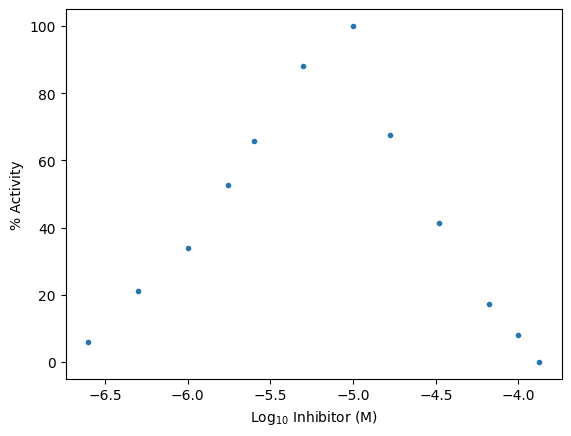

In [6]:
data = {}
data['x'] = x
data['y'] = scaling_data(y, min(y), max(y))

plt.plot(data['x'], data['y'], '.')
plt.xlabel("Log$_{10}$ Inhibitor (M)")
plt.ylabel("% Activity");

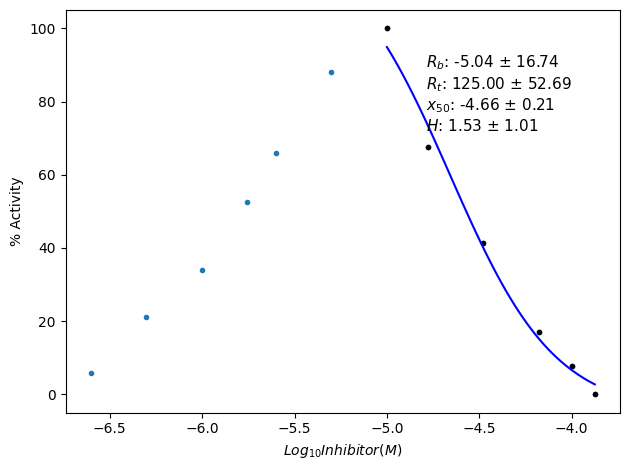

In [7]:
[theta, ASE, var] = estimate_theta_downward_curve(data)
[R_b, R_t, x50, H] = theta

# Test 2

Loading input data given its name.

In [8]:
file_name = "/content/drive/MyDrive/MoonShot/dimer/input/Input_Curve.csv"

# Read the CSV file
data = pd.read_csv(file_name)
data

,Log10_Inhibitor,Percentage_Activity
0,-13.815511,28.438878
1,-13.396859,43.898342
2,-12.978207,62.027221
3,-12.559555,80.575488
4,-12.140903,95.193721
5,-11.722251,100.000000
6,-11.303600,90.720157
7,-10.884948,69.658028
8,-10.466296,45.364887
9,-10.047644,24.875981


We change the name of column to 'x' and 'y'.

In [9]:
data = data.rename(columns={"Log10_Inhibitor": "x", "Percentage_Activity": "y"})
data

,x,y
0,-13.815511,28.438878
1,-13.396859,43.898342
2,-12.978207,62.027221
3,-12.559555,80.575488
4,-12.140903,95.193721
5,-11.722251,100.000000
6,-11.303600,90.720157
7,-10.884948,69.658028
8,-10.466296,45.364887
9,-10.047644,24.875981


We provide the outfile so that the plot can be saved.

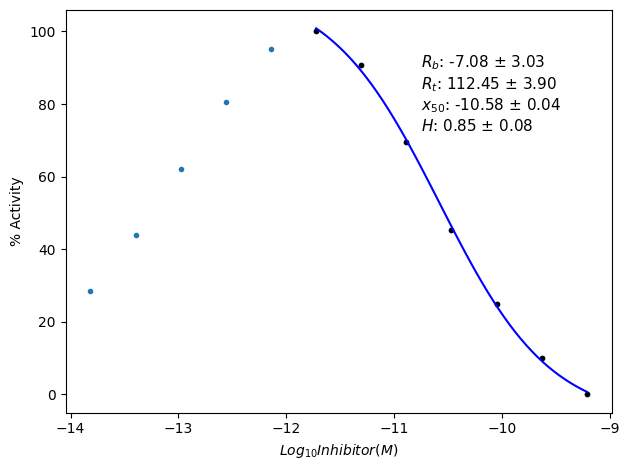

In [10]:
outfile = "/content/drive/MyDrive/MoonShot/dimer/output/curve.png"
[theta, ASE, var] = estimate_theta_downward_curve(data=data, outfile=outfile)
[R_b, R_t, x50, H] = theta

# Test 3

Below: 
- x: array, converted from concentration of inhibitor (unit: M) to $log_{10}$ of concentration
- y: array, raw response of velocity (unit: M min$^{-1}$)

In [5]:
x = np.log10(np.array([0.25, 0.5, 1, 1.75, 2.5, 5])*1E-6) #M
y = np.array([0.1204, 0.1862, 0.243, 0.3234, 0.3816, 0.4788])*1E-6 # M min^{-1}

y will be scaled to %Activity before fitting the curve.

In [6]:
data = {}
data['x'] = x
data['y'] = scaling_data(y, min(y), max(y))

This curve goes upward!


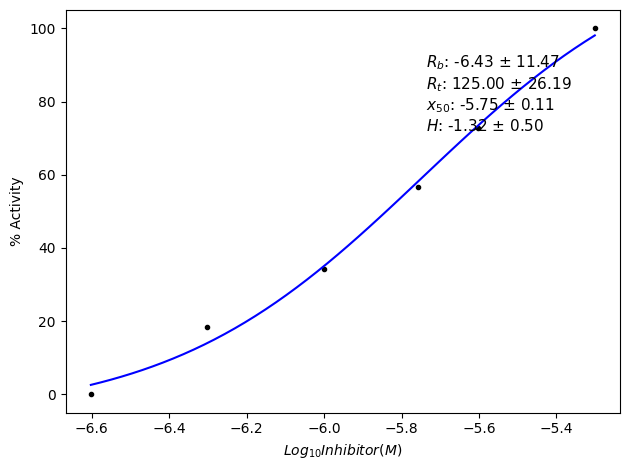

In [7]:
[theta, ASE, var] = estimate_theta_downward_curve(data)

# Test 4

In [8]:
file_name = "/content/drive/MyDrive/MoonShot/dimer/input/Input_Curve_3_rep.csv"

# Read the CSV file
data = pd.read_csv(file_name)
data.head()

,Log10_Inhibitor,Percentage_Activity
0,-13.8155,27.8048
1,-13.8155,24.9186
2,-13.8155,27.9258
3,-13.3969,45.8370
4,-13.3969,43.6765


We change the name of column to 'x' and 'y'.

In [9]:
data = data.rename(columns={"Log10_Inhibitor": "x", "Percentage_Activity": "y"})
data.head()

,x,y
0,-13.8155,27.8048
1,-13.8155,24.9186
2,-13.8155,27.9258
3,-13.3969,45.8370
4,-13.3969,43.6765


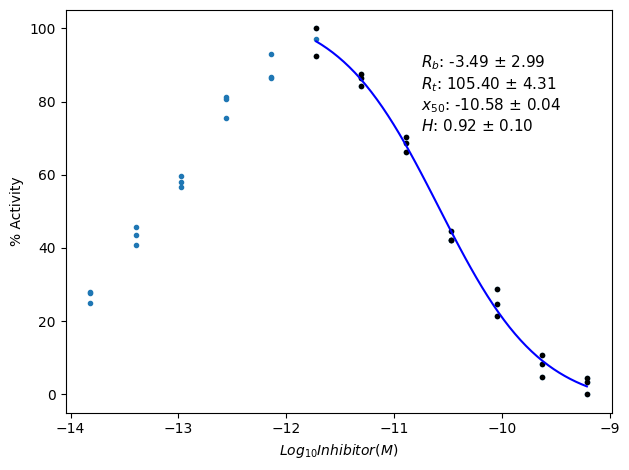

In [10]:
outfile = "/content/drive/MyDrive/MoonShot/dimer/output/curve_3_reps.png"
[theta, ASE, var] = estimate_theta_downward_curve(data=data, outfile=outfile)
[R_b, R_t, x50, H] = theta